In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
# solve the problem of "libdevice not found at ./libdevice.10.bc"
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/r10222035/.conda/envs/tf2'

2024-09-27 19:34:03.287229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 19:34:03.372098: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# 生成假資料 n 維的高斯分佈

mu1 = [0, 0, 0, 0, 0]
cov1 = np.eye(5)
mu2 = [1, 1, 1, 1, 1]
cov2 = np.eye(5)

def generate_data(n_samples=10000):
    f1 = 0.6
    f2 = 0.4

    n_sig_1, n_bkg_1 = int(n_samples * f1), int(n_samples * (1 - f1))
    n_sig_2, n_bkg_2 = int(n_samples * f2), int(n_samples * (1 - f2))

    M1 = np.concatenate([np.random.multivariate_normal(mu1, cov1, size=n_sig_1), 
                         np.random.multivariate_normal(mu2, cov2, size=n_bkg_1)])
    M2 = np.concatenate([np.random.multivariate_normal(mu1, cov1, size=n_sig_2), 
                         np.random.multivariate_normal(mu2, cov2, size=n_bkg_2)])

    X = np.concatenate([M1, M2])
    y = np.array([1] * M1.shape[0]  + [0] * M2.shape[0])
    y_true = np.array([1] * n_sig_1 + [0] * n_bkg_1 + [1] * n_sig_2 + [0] * n_bkg_2)
    return X, y, y_true

In [3]:
X_test = np.concatenate([np.random.multivariate_normal(mu1, cov1, size=1000), 
                         np.random.multivariate_normal(mu2, cov2, size=1000)])
y_test = np.array([1] * 1000 + [0] * 1000)

In [4]:
# 建立神經網路模型
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(8, input_dim=input_dim, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [5]:
class MyTestingCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super(MyTestingCallback, self).__init__()
        self.test_data = test_data
        self.testing_loss = []
        self.testing_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        # Test on another dataset
        results = self.model.evaluate(x=self.test_data[0], y=self.test_data[1], batch_size=1024)
        self.testing_loss.append(results[0])
        print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

        # Compute ACC
        y_pred = self.model.predict(self.test_data[0], batch_size=1024)
        ACC = get_highest_accuracy(self.test_data[1], y_pred)
        self.testing_accuracy.append(ACC)
        print(f'True ACC: Testing Loss = {results[0]:.3}, Testing Accuracy = {ACC:.3}')

def get_highest_accuracy(y_true, y_pred):
    _, _, thresholds = roc_curve(y_true, y_pred)
    # compute highest accuracy
    thresholds = np.array(thresholds)
    if len(thresholds) > 1000:
        thresholds = np.percentile(thresholds, np.linspace(0, 100, 1001))
    accuracy_scores = []
    for threshold in thresholds:
        accuracy_scores.append(accuracy_score(y_true, y_pred>threshold))

    accuracies = np.array(accuracy_scores)
    return accuracies.max()

In [6]:
def plot_event_distribution(X, y, y_true, save_path=None):
    if X.shape[0] > 400:
        idx = np.random.choice(X.shape[0], 400, replace=False)
        X = X[idx]
        y = y[idx]
        y_true = y_true[idx]
        
    # 畫訓練資料
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].scatter(X[(y==1) & (y_true==1)][:, 0], X[(y==1) & (y_true==1)][:, 1], c='r', marker='+', alpha=0.3, label='signal in $M_1$')
    ax[0].scatter(X[(y==0) & (y_true==1)][:, 0], X[(y==0) & (y_true==1)][:, 1], c='blue', marker='x', alpha=0.3, label='signal in $M_2$')
    ax[0].scatter(X[(y==1) & (y_true==0)][:, 0], X[(y==1) & (y_true==0)][:, 1], c='lightcoral', marker='+', alpha=0.3, label='background in $M_1$')
    ax[0].scatter(X[(y==0) & (y_true==0)][:, 0], X[(y==0) & (y_true==0)][:, 1], c='royalblue', marker='x', alpha=0.3, label='background in $M_2$')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')

    ax[0].set_xlim(-5, 10)
    ax[0].set_ylim(-5, 10)

    ax[1].scatter(X[(y==1) & (y_true==1)][:, 0], X[(y==1) & (y_true==1)][:, 1], c='r', marker='+', alpha=0.5, label='$M_1$')
    ax[1].scatter(X[(y==0) & (y_true==1)][:, 0], X[(y==0) & (y_true==1)][:, 1], c='b', marker='x', alpha=0.5, label='$M_2$')
    ax[1].set_xlim(-5, 10)
    ax[1].set_ylim(-5, 10)
    ax[1].legend(frameon=False)
    ax[1].set_title('Signal')
    ax[1].set_xlabel('Feature 1')
    ax[1].set_ylabel('Feature 2')

    ax[2].scatter(X[(y==1) & (y_true==0)][:, 0], X[(y==1) & (y_true==0)][:, 1], c='lightcoral', marker='+', alpha=0.5, label='$M_1$')
    ax[2].scatter(X[(y==0) & (y_true==0)][:, 0], X[(y==0) & (y_true==0)][:, 1], c='royalblue', marker='x', alpha=0.5, label='$M_2$')
    ax[2].set_xlim(-5, 10)
    ax[2].set_ylim(-5, 10)
    ax[2].legend(frameon=False)
    ax[2].set_title('Background')
    ax[2].set_xlabel('Feature 1')
    ax[2].set_ylabel('Feature 2')

    if save_path:
        plt.savefig(save_path, dpi=300, facecolor='White', bbox_inches='tight')
    plt.show()

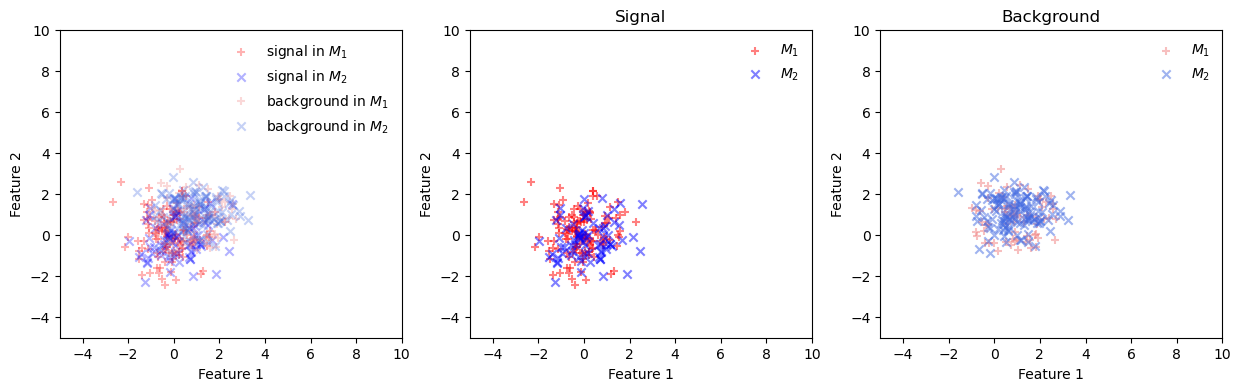

In [7]:
X_train, y_train, y_true = generate_data()
X_val, y_val, y_true_val = generate_data(n_samples=1000)

save_path = './figures/bootstrapping_training_data_original.pdf'
plot_event_distribution(X_train, y_train, y_true, save_path)

Iteration 1
M1: sig: 6000, bkg: 4000
M2: sig: 4000, bkg: 6000


2024-09-27 19:34:09.982215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 19:34:10.594111: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


Epoch 1/50


2024-09-27 19:34:12.647766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-09-27 19:34:12.651574: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x557f5fed1160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-27 19:34:12.651624: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-27 19:34:12.663294: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-27 19:34:12.807688: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2/2 [==============================] - 0s 4ms/step - loss: 0.6271 - accuracy: 0.8235
Testing Loss = 0.627, Testing Accuracy = 0.823
2/2 [==============================] - 0s 3ms/step
True ACC: Testing Loss = 0.627, Testing Accuracy = 0.826
20/20 [==============================] - 3s 30ms/step - loss: 0.6998 - accuracy: 0.5396 - val_loss: 0.6867 - val_accuracy: 0.5575
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 0.5917 - accuracy: 0.8285
Testing Loss = 0.592, Testing Accuracy = 0.828
2/2 [==============================] - 0s 2ms/step
True ACC: Testing Loss = 0.592, Testing Accuracy = 0.858
20/20 [==============================] - 0s 18ms/step - loss: 0.6827 - accuracy: 0.5716 - val_loss: 0.6852 - val_accuracy: 0.5640
Epoch 3/50
2/2 [==============================] - 0s 4ms/step - loss: 0.5908 - accuracy: 0.8650
Testing Loss = 0.591, Testing Accuracy = 0.865
2/2 [==============================] - 0s 3ms/step
True ACC: Testing Loss = 0.591, Testing Accuracy = 0.86

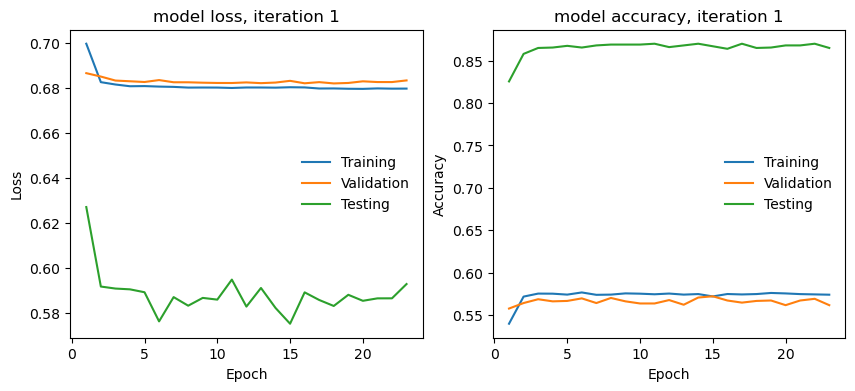

63/63 [==============================] - 0s 1ms/step


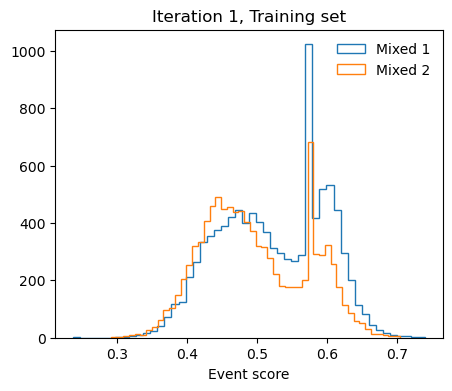

20/20 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5756
Training Loss = 0.679, Training Accuracy = 0.576
2/2 [==============================] - 0s 5ms/step


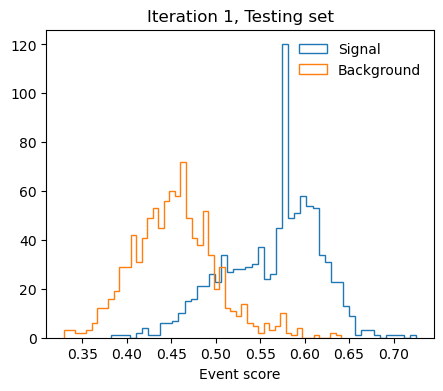

2/2 [==============================] - 0s 4ms/step - loss: 0.5928 - accuracy: 0.8610
Testing Loss = 0.593, Testing Accuracy = 0.861


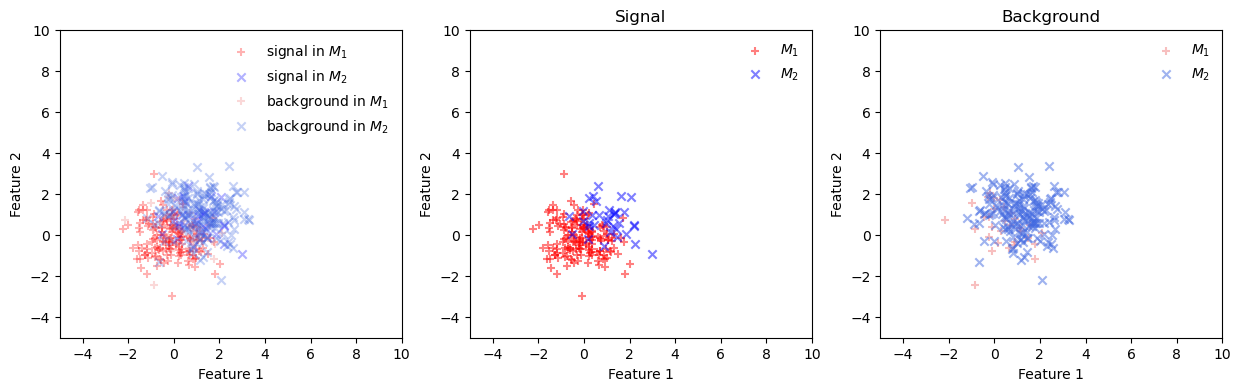

Iteration 2
M1: sig: 8600, bkg: 1400
M2: sig: 1400, bkg: 8600
Epoch 1/50
2/2 [==============================] - 0s 4ms/step - loss: 0.6224 - accuracy: 0.7250
Testing Loss = 0.622, Testing Accuracy = 0.725
2/2 [==============================] - 0s 2ms/step
True ACC: Testing Loss = 0.622, Testing Accuracy = 0.75
20/20 [==============================] - 1s 25ms/step - loss: 0.7183 - accuracy: 0.5486 - val_loss: 0.6165 - val_accuracy: 0.7485
Epoch 2/50
2/2 [==============================] - 0s 4ms/step - loss: 0.5266 - accuracy: 0.7880
Testing Loss = 0.527, Testing Accuracy = 0.788
2/2 [==============================] - 0s 2ms/step
True ACC: Testing Loss = 0.527, Testing Accuracy = 0.83
20/20 [==============================] - 0s 17ms/step - loss: 0.5616 - accuracy: 0.7853 - val_loss: 0.5048 - val_accuracy: 0.8325
Epoch 3/50
2/2 [==============================] - 0s 4ms/step - loss: 0.4508 - accuracy: 0.8560
Testing Loss = 0.451, Testing Accuracy = 0.856
2/2 [==============================

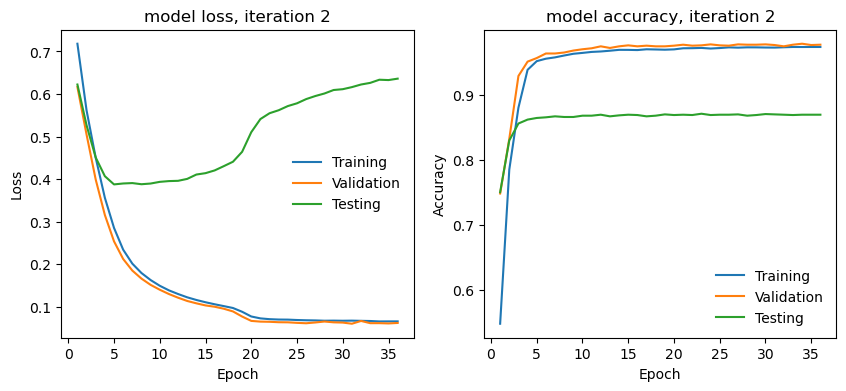

63/63 [==============================] - 0s 1ms/step


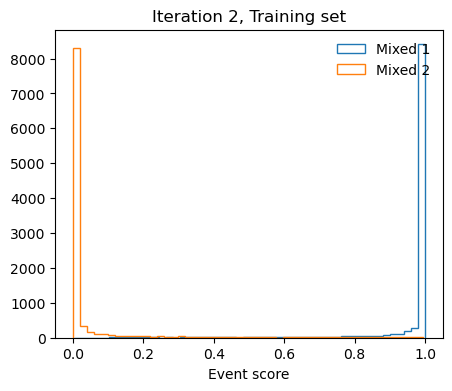

20/20 [==============================] - 0s 2ms/step - loss: 0.0647 - accuracy: 0.9744
Training Loss = 0.0647, Training Accuracy = 0.974
2/2 [==============================] - 0s 3ms/step


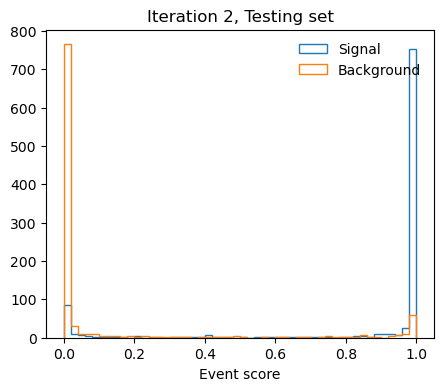

2/2 [==============================] - 0s 4ms/step - loss: 0.6362 - accuracy: 0.8680
Testing Loss = 0.636, Testing Accuracy = 0.868


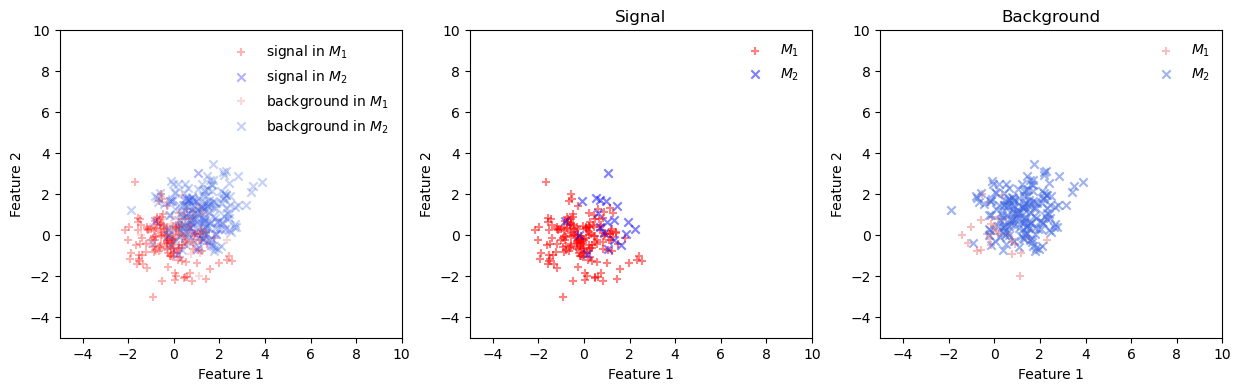

Iteration 3
M1: sig: 8638, bkg: 1362
M2: sig: 1362, bkg: 8638
Epoch 1/50
2/2 [==============================] - 0s 5ms/step - loss: 0.4905 - accuracy: 0.8165
Testing Loss = 0.49, Testing Accuracy = 0.817
2/2 [==============================] - 0s 2ms/step
True ACC: Testing Loss = 0.49, Testing Accuracy = 0.841
20/20 [==============================] - 1s 26ms/step - loss: 0.5291 - accuracy: 0.7673 - val_loss: 0.4192 - val_accuracy: 0.8675
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3791 - accuracy: 0.8560
Testing Loss = 0.379, Testing Accuracy = 0.856
2/2 [==============================] - 0s 3ms/step
True ACC: Testing Loss = 0.379, Testing Accuracy = 0.859
20/20 [==============================] - 0s 20ms/step - loss: 0.3305 - accuracy: 0.9079 - val_loss: 0.2245 - val_accuracy: 0.9380
Epoch 3/50
2/2 [==============================] - 0s 4ms/step - loss: 0.3950 - accuracy: 0.8685
Testing Loss = 0.395, Testing Accuracy = 0.868
2/2 [==============================

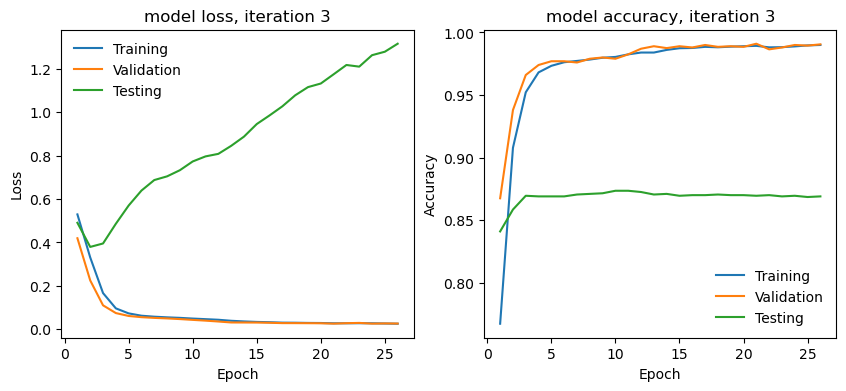

63/63 [==============================] - 0s 1ms/step


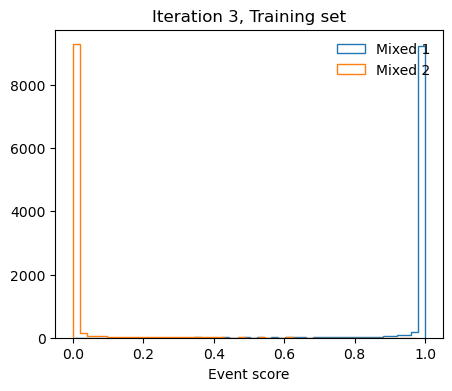

20/20 [==============================] - 0s 2ms/step - loss: 0.0250 - accuracy: 0.9897
Training Loss = 0.025, Training Accuracy = 0.99
2/2 [==============================] - 0s 2ms/step


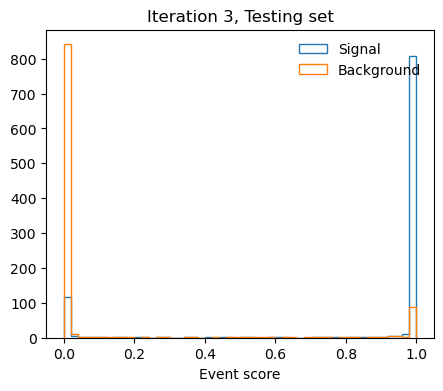

2/2 [==============================] - 0s 4ms/step - loss: 1.3164 - accuracy: 0.8670
Testing Loss = 1.32, Testing Accuracy = 0.867


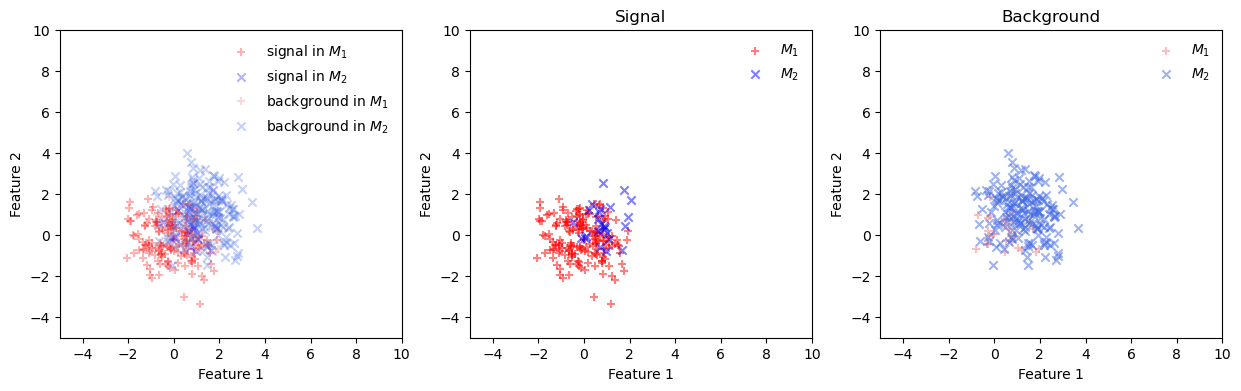

In [8]:
# 迭代重新分配資料和訓練
n_iterations = 3
for iteration in range(n_iterations):
    print(f'Iteration {iteration + 1}')
    
    # 檢查每個類別的數量
    n_sig_1 = np.sum(y_true[y_train == 1] == 1)
    n_bkg_1 = np.sum(y_true[y_train == 1] == 0)
    n_sig_2 = np.sum(y_true[y_train == 0] == 1)
    n_bkg_2 = np.sum(y_true[y_train == 0] == 0)
    print(f'M1: sig: {n_sig_1}, bkg: {n_bkg_1}')
    print(f'M2: sig: {n_sig_2}, bkg: {n_bkg_2}')

    testing_callback = MyTestingCallback((X_test, y_test))

    # 建立模型並訓練
    model = build_model(X_train.shape[1])
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=5)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1024, verbose=1, 
                        callbacks=[
                                    early_stopping,
                                    testing_callback,
                               ])

    # plot the training loss, accuracy
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    x = range(1, len(history.history['loss']) + 1)

    ax[0].plot(x, history.history['loss'], label='Training')
    ax[0].plot(x, history.history['val_loss'], label='Validation')
    ax[0].plot(x, testing_callback.testing_loss, label='Testing')

    ax[0].legend(frameon=False)
    ax[0].set_title(f'model loss, iteration {iteration + 1}')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(x, history.history['accuracy'], label='Training')
    ax[1].plot(x, history.history['val_accuracy'], label='Validation')
    ax[1].plot(x, testing_callback.testing_accuracy, label='Testing')

    ax[1].legend(frameon=False)
    ax[1].set_title(f'model accuracy, iteration {iteration + 1}')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    plt.show()


    # 利用模型重新分配訓練資料集
    y_predict = model.predict(X_train, batch_size=1024)
    # 找出 50% 的分界值
    threshold = np.percentile(y_predict, 50)
    y_train_new = (y_predict > threshold).astype(int).flatten()
    
    y_val_predict = model.predict(X_val)
    y_val_new = (y_val_predict > threshold).astype(int).flatten()

    # 畫 event score 的分布
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.hist(y_predict[y_train == 1], bins=50, histtype='step', label='Mixed 1')
    ax.hist(y_predict[y_train == 0], bins=50, histtype='step', label='Mixed 2')
    ax.legend(frameon=False)
    ax.set_title(f'Iteration {iteration + 1}, Training set')
    ax.set_xlabel('Event score')
    plt.show()

    results = model.evaluate(x=X_train, y=y_train, batch_size=1024)
    print(f'Training Loss = {results[0]:.3}, Training Accuracy = {results[1]:.3}')

    # 利用模型重新分配訓練資料集
    y_test_predict = model.predict(X_test, batch_size=1024)

    # 畫 event score 的分布
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.hist(y_test_predict[y_test == 1], bins=50, histtype='step', label='Signal')
    ax.hist(y_test_predict[y_test == 0], bins=50, histtype='step', label='Background')
    ax.legend(frameon=False)
    ax.set_title(f'Iteration {iteration + 1}, Testing set')
    ax.set_xlabel('Event score')
    plt.show()

    results = model.evaluate(x=X_test, y=y_test, batch_size=1024)
    print(f'Testing Loss = {results[0]:.3}, Testing Accuracy = {results[1]:.3}')

    save_path = f'./figures/bootstrapping_training_data_iteration_{iteration + 1}.pdf'
    plot_event_distribution(X_train, y_train_new, y_true, save_path)

    # 可以選擇重新合併兩個新的資料集或分別訓練不同的模型
    # 這裡假設繼續用原模型的預測結果來進行下一次迭代的訓練
    y_train = y_train_new
    y_val = y_val_new